In [1]:
import sys
sys.path.insert(0, '../attention-is-all-you-need/')
sys.path.insert(0, '../modeling/')
sys.argv = ['']

In [2]:
import os
import dill
import random
import glob
import setting
import torch
import numpy as np
import sentencepiece as spm
import argparse
import torch.distributed as dist
#import torch.multiprocessing as mp
import logging
import logging.config

from visdom import Visdom
from utils import fix_torch_randomness, get_sentencepiece, get_number_of_params
from transformer import make_model, subsequent_mask
from dataset import load_dataset_aihub, KRENDataset, KRENField, MyIterator, batch_size_fn
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.autograd import Variable
from setting import *
from feature import *

In [3]:
# define logger
logging.config.fileConfig('../attention-is-all-you-need/logging.conf')
log = logging.getLogger('LaH')

In [4]:
# define ENV variables
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '10002'

In [5]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask,
                           Variable(ys),
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument('--world_size', default=setting.world_size, type=int)
parser.add_argument('--multi_gpu', default=setting.multi_gpu, type=bool)
parser.add_argument('--modelnm', default='a.bin', type=str)
parser.add_argument('--N', default=setting.N, type=int)
parser.add_argument('--d_model', default=setting.d_model, type=int)
parser.add_argument('--d_ff', default=setting.d_ff, type=int)
parser.add_argument('--h', default=setting.h, type=int)
parser.add_argument('--dropout', default=0.0, type=float)
parser.add_argument('--small_model', default=False, type=bool)

_StoreAction(option_strings=['--small_model'], dest='small_model', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, help=None, metavar=None)

In [7]:
args = parser.parse_args()

In [8]:
sent_pairs = load_dataset_aihub(path='../attention-is-all-you-need/data/')
#sent_pairs = load_dataset_aihub()

In [9]:
src_spm = spm.SentencePieceProcessor()
trg_spm = spm.SentencePieceProcessor()
src_spm.Load('../attention-is-all-you-need/spm/{}.model'.format(src_prefix))
trg_spm.Load('../attention-is-all-you-need/spm/{}.model'.format(trg_prefix))

True

In [10]:
inp_lang, out_lang = src_spm, trg_spm

In [11]:
extra_options = 'bos:eos' #'reverse:bos:eos'
#src_spm.SetEncodeExtraOptions(extra_options)
trg_spm.SetEncodeExtraOptions(extra_options)
log.info('loaded input sentencepiece model: {}'.format(src_prefix))
log.info('loaded output sentencepiece model: {}'.format(trg_prefix))

[INFO] (<ipython-input-11-14a64b6c78f5>:4) > loaded input sentencepiece model: spm-src-50000
[INFO] (<ipython-input-11-14a64b6c78f5>:5) > loaded output sentencepiece model: spm-trg-32000


In [12]:
# split train/valid sentence pairs
n_train = int(len(sent_pairs) * 0.8)
valid_sent_pairs = sent_pairs[n_train:]
log.info('valid_sent_pairs: {}'.format(len(valid_sent_pairs)))

[INFO] (<ipython-input-12-47613aab77f2>:4) > valid_sent_pairs: 13253


In [13]:
# these are used for defining tokenize method and some reserved words
SRC = KRENField(pad_token='<pad>')
TRG = KRENField(pad_token='<pad>')

In [14]:
SRC.decode = inp_lang.DecodeIds
TRG.decode = out_lang.DecodeIds
SRC.encode = inp_lang.EncodeAsIds
TRG.encode = out_lang.EncodeAsIds

In [15]:
src_vocab = torch.load('../attention-is-all-you-need/spm/{}.spm'.format(src_prefix), pickle_module=dill)
trg_vocab = torch.load('../attention-is-all-you-need/spm/{}.spm'.format(trg_prefix), pickle_module=dill)
SRC.vocab = src_vocab
TRG.vocab = trg_vocab
log.info('input vocab was loaded: spm/{}.spm'.format(src_prefix))
log.info('output vocab was loaded: spm/{}.spm'.format(trg_prefix))

[INFO] (<ipython-input-15-a799ae4d4d42>:5) > input vocab was loaded: spm/spm-src-50000.spm
[INFO] (<ipython-input-15-a799ae4d4d42>:6) > output vocab was loaded: spm/spm-trg-32000.spm


In [16]:
# make dataloader from KRENDataset
train, valid, test = KRENDataset.splits(sent_pairs, (SRC, TRG), inp_lang, out_lang, encoding_type='pieces')
valid_iter = MyIterator(valid, batch_size=100, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

Encoding as pieces: 100%|██████████| 1254/1254 [00:00<00:00, 16846.21it/s]


In [17]:
# fix torch randomness
fix_torch_randomness()

In [18]:
# define input/output size
args.inp_n_words = src_vocab_size
args.out_n_words = trg_vocab_size
log.info('inp_n_words: {} out_n_words: {}'.format(args.inp_n_words, args.out_n_words))

[INFO] (<ipython-input-18-fe544bfaea37>:4) > inp_n_words: 50000 out_n_words: 32000


In [19]:
if False:
    model = make_model(
        args.inp_n_words,
        args.out_n_words,
        dropout=args.dropout)
else:
    model = make_model(
        args.inp_n_words,
        args.out_n_words,
        N=N,
        d_model=args.d_model,
        d_ff=args.d_ff,
        h=args.h,
        dropout=args.dropout)

../modeling/transformer.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [20]:
model_name_full_path = '../attention-is-all-you-need/models/final_model.bin'
device = torch.device('cpu')
checkpoint = torch.load(model_name_full_path, map_location=device)
state_dict = checkpoint['state_dict']
model.load_state_dict(state_dict)
#model.cuda()

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [21]:
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.1)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=1024, out_features=4096, bias=True)
          (w_2): Linear(in_features=4096, out_features=1024, bias=True)
          (dropout): Dropout(p=0.0)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0

In [25]:
for i, batch in enumerate(valid_iter):
    if i == 20:
        break
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<pad>"]).unsqueeze(-2)

    
    out = greedy_decode(model, src, src_mask,
                        max_len=60, start_symbol=TRG.vocab.stoi["<s>"])
    
    
    print("Input::", end="\t")
    src_list = []
    for i in range(src.size(1)):
        sym = SRC.vocab.itos[src[0, i].data.item()]
        src_list.append(src[0, i].data.item())
        if sym == "</s>": break
        #print(sym, end =" ")
    print(SRC.decode(src_list))
    print('')
    
    print("Translation:", end="\t")
    trg_list = []
    for i in range(1, out.size(1)):
        sym = TRG.vocab.itos[out[0, i].data.item()]
        trg_list.append(out[0, i].data.item())
        if sym == "</s>": break
        #print(sym, end =" ")
    print(TRG.decode(trg_list))
    print('')
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TRG.vocab.itos[batch.trg.data[i, 0].data.item()]
        if sym == "</s>": break
        print(sym, end =" ")
    print('')
    print('---------------')

Input::	여성뿐만이 아니에요.

Translation:	Women are not the same as women.

Target:	▁It ▁is ▁not ▁only ▁for ▁women . 
---------------
Input::	저희도 와이파이 비밀번호를 몰라요.

Translation:	I don't know the wifi password.

Target:	▁We ▁also ▁don ' t ▁know ▁the ▁wifi ▁password . 
---------------
Input::	나는 스마트폰이 유용하다고 생각해요.

Translation:	I think smartphones are useful.

Target:	▁I ▁think ▁smartphones ▁are ▁useful . 
---------------
Input::	당신은 로맨틱한 남자를 좋아하나요?

Translation:	Do you like romantic guy?

Target:	▁Do ▁you ▁like ▁a ▁romantic ▁guy ? 
---------------
Input::	결핵약을 어떻게 먹어야하죠?

Translation:	How can I get to the United States?

Target:	▁How ▁can ▁I ▁take ▁this ▁tuberculosis ▁medicine ? 
---------------
Input::	열심히 노력해서 꼭 승무원이 되세요.

Translation:	I hope you will be a flight attendant.

Target:	▁Try ▁hard ▁to ▁be ▁a ▁flight ▁attendant . 
---------------
Input::	하고 싶은 다른 직업이 있나요?

Translation:	Do you want to work with other jobs?

Target:	▁Are ▁there ▁any ▁other ▁jobs ▁that ▁you ▁want ? 
---------------
Inpu

In [23]:
n_params = get_number_of_params(model)

In [24]:
n_params/10**6

293.129472

### draw attention plot

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
#tgt_sent = trans.split()
sent = inp_lang.EncodeAsIds(sent_pairs[0][0])
tgt_sent = out_lang.EncodeAsIds(sent_pairs[0][1])[:-1]

In [29]:
len(sent), len(tgt_sent)

(11, 13)

In [30]:
def draw(data, x, y, ax):
    sns.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)

Encoder Layer 2
[DEBUG] (font_manager.py:1246) > findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldObli

[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'NanumBarunGothic' (NanumBarunGothic.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal bold normal>) = 10.335
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'NanumGothic Eco' (NanumGothicEcoExtraBold.ttf) normal normal bold normal>) = 10.335
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'Ubuntu' (Ubuntu-B.ttf) normal normal bold normal>) = 10.335
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'UnGraphic' (UnGraphicBold.ttf) normal normal bold normal>) = 10.335
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'Baekmuk Gulim' (gulim.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal bold normal>) = 10.335
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-R.ttf) normal normal 400 nor

[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'UnJamoBatang' (UnJamoBatang.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'NanumMyeongjo Eco' (NanumMyeongjoEco.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'Ubuntu' (Ubuntu-R.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'D2Coding' (D2Coding-Ver1.3.2-20180524.ttc) normal normal 400 normal>) = 10.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'NanumSquare' (NanumSquareR.ttf) normal normal regular normal>) = 10.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'D2Coding' (D2Coding-Ver1.3.2-20180524-all.ttc) normal normal 400 normal>) = 10.05
[DEBUG] (font_manager.py:1258) > findfont: score(<Font 'NanumSquareRound' (NanumSquareRoundEB.ttf) norm

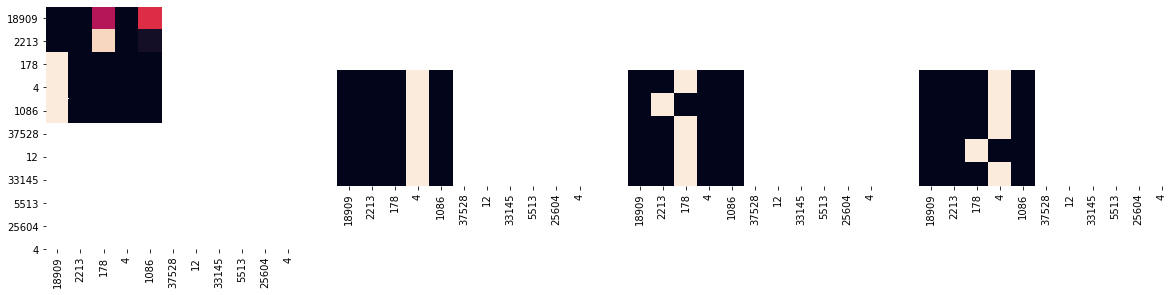

Encoder Layer 4


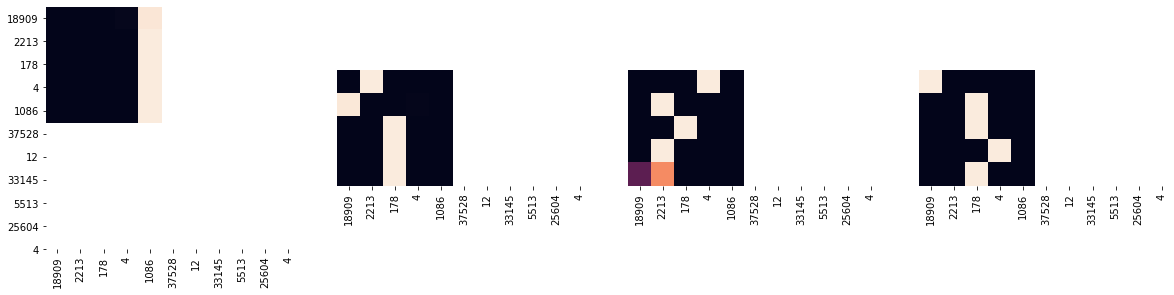

Encoder Layer 6


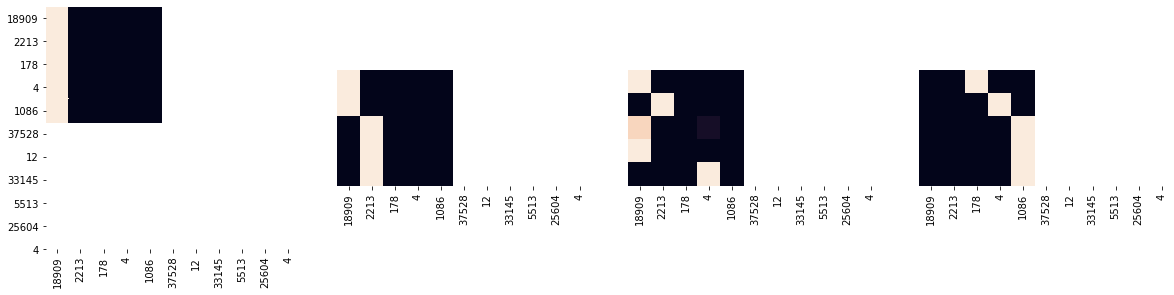

In [31]:
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()

Decoder Self Layer 2


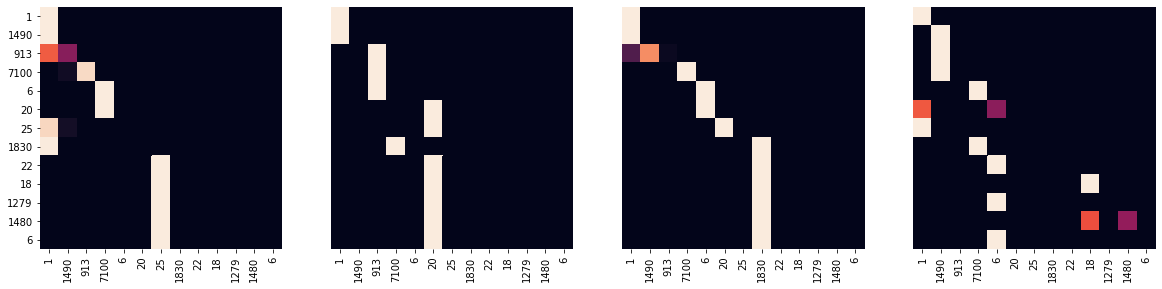

Decoder Src Layer 2


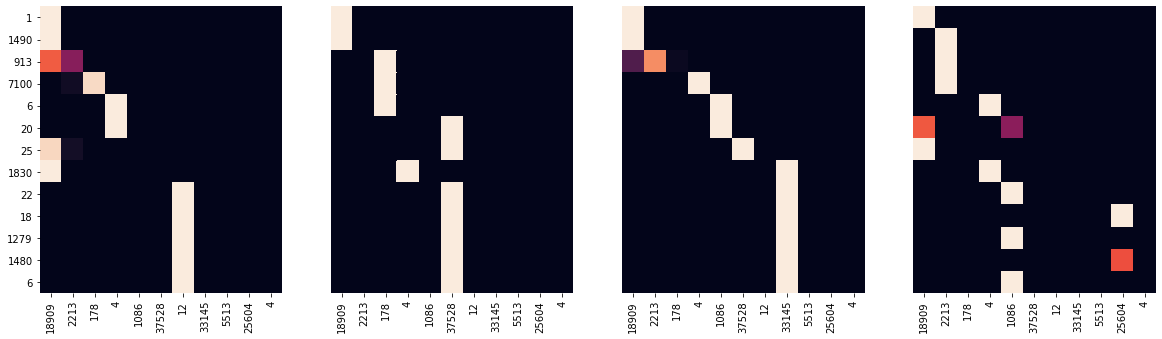

Decoder Self Layer 4


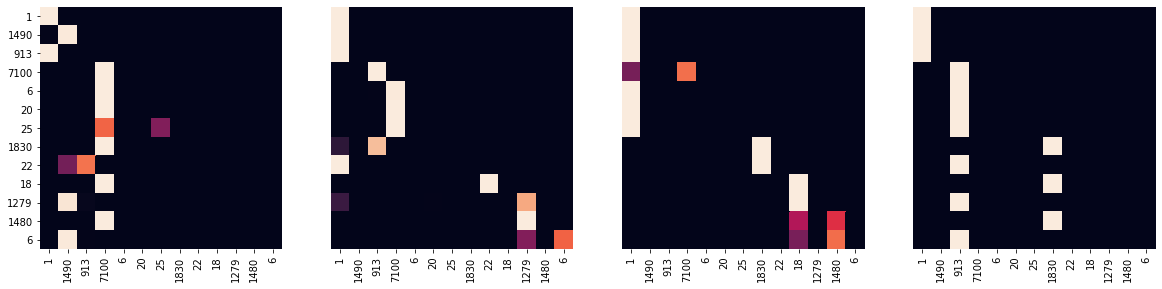

Decoder Src Layer 4


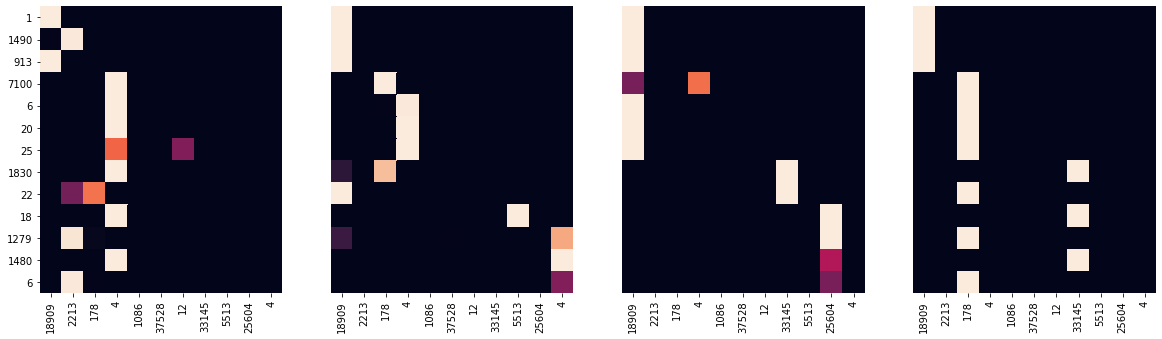

Decoder Self Layer 6


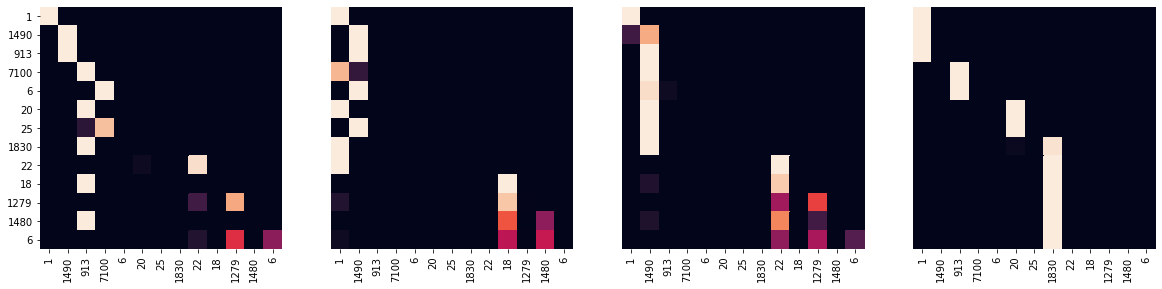

Decoder Src Layer 6


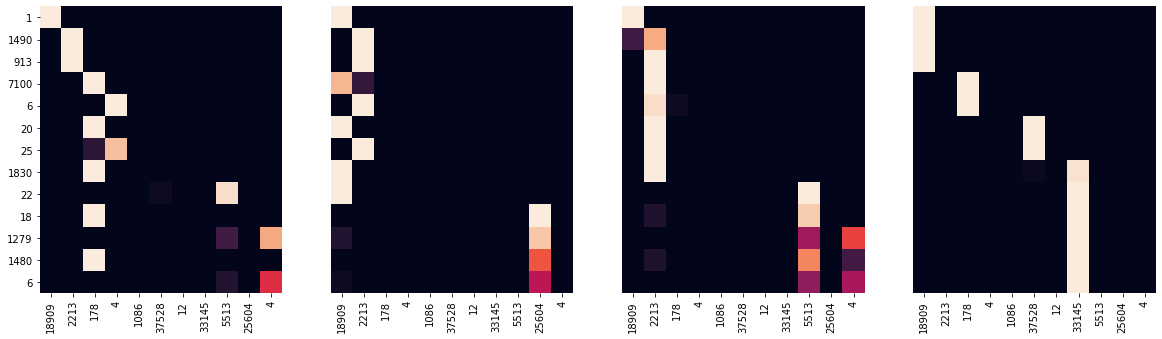

In [32]:
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()

In [33]:
model.decoder.layers[layer].self_attn.attn[0, h].shape

torch.Size([59, 59])

In [34]:
model.decoder.layers[layer].self_attn.dropout

Dropout(p=0.1)